In [1]:
from datetime import datetime, timedelta, date
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import sys
import numpy as np
sys.path.append('../')
sns.set()

Read the datasets:

In [2]:
texts = pd.read_csv('../annotations/data/classification_dataset.csv').dropna(subset=['text'])
tags = pd.read_csv('../wykop_scraper/data/latest/tags.csv')

In [3]:
texts.head()

,Unnamed: 0,comment_id,entry_id,date,text,author_login,vote_count,receiver,hate_word_counts,is_hateful,annotation
0,0,185386257,52292479,2020-09-23 00:18:39,Ty no kurwa że też ja na to nie wpadłem ale ze...,Cybek-Marian,1,atteint,2,1,0
1,3,174804569,49417029,2020-05-14 19:45:44,coś ponad 1 a mniej niż 2,wytrzzeszcz,1,Kosciany,0,0,0
2,6,189533891,53440779,2020-11-09 20:41:58,Motor ma już w garażu,piSSowiec39,3,Zagmadfany2,0,0,0
3,9,172538589,48804329,2020-04-17 01:00:24,znow robic na tego zlodzieja,ranunculus,3,Graner,0,0,0
4,12,185485247,52313979,2020-09-24 11:51:11,kurwa człowieku no do kurwy nędzy chociaż wytn...,Cybek-Marian,0,AgentGRU,3,1,1


# Dataset analysis

In [4]:
print(f'Number of texts: {len(texts.index)}')

Number of texts: 5821


In [5]:
word_length = [len(x.split(' ')) for x in texts['text']]
char_length = [len(x) for x in texts['text']]
print(f"Average word length: {sum(word_length)/len(word_length)}")
print(f"Average char length: {sum(char_length)/len(char_length)}")

Average word length: 16.361965298058752
Average char length: 94.49115272289984


(0.0, 100.0)

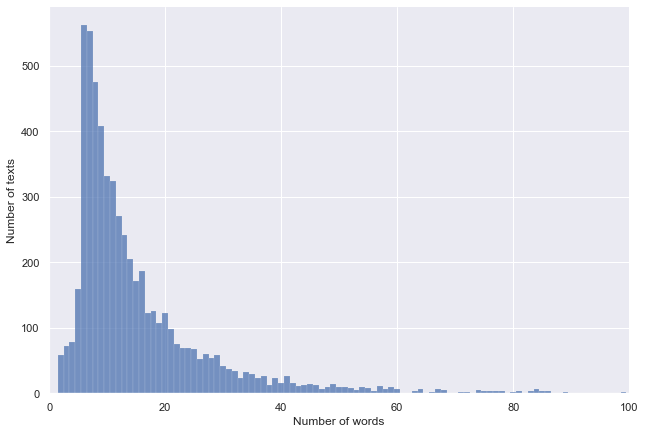

In [6]:
sns.displot(x=word_length, height=6, aspect=1.5, discrete=True)
plt.xlabel("Number of words")
plt.ylabel('Number of texts')
plt.xlim(0, 100)

In [7]:
print(f"Number of lexts longer than 100 words: {(np.array(word_length)>100).sum()}")

Number of lexts longer than 100 words: 43


(0.0, 500.0)

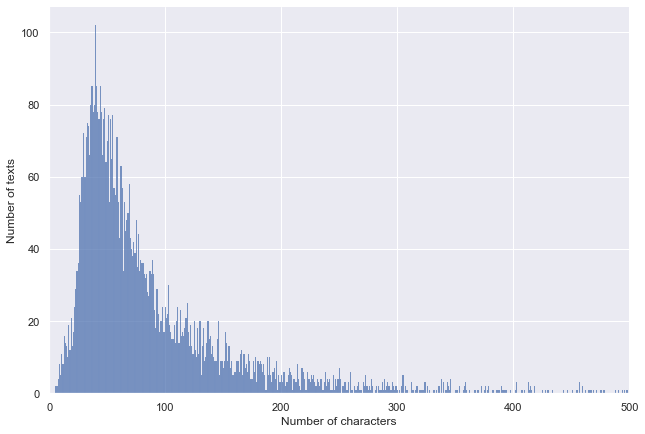

In [8]:
sns.displot(x=char_length, height=6, aspect=1.5, discrete=True)
plt.xlabel("Number of characters")
plt.ylabel('Number of texts')
plt.xlim(0, 500)

In [9]:
print(f"Number of lexts longer than 500 characters: {(np.array(char_length)>500).sum()}")

Number of lexts longer than 500 characters: 70


# Hate words analysis

In [63]:
from unidecode import unidecode
from wykop_scraper.hatebase import hate_words, curse_words

hate_words = set([unidecode(hw.lower()) for hw in hate_words])
curse_words = set([unidecode(w.lower()) for w in curse_words])

In [11]:
def is_word_hateful(word):
    return any(hw in word for hw in hate_words) or any(cw in word for cw in curse_words)

def count_hate_words(text):
    text = unidecode(text)
    words = re.findall('\w+', text)
    return sum([1 if is_word_hateful(w) else 0 for w in words])

texts['hate_word_counts'] = texts.text.str.lower().apply(count_hate_words)

In [12]:
texts['hate_word_counts'].value_counts()

0    5236
1     501
2      75
3       8
4       1
Name: hate_word_counts, dtype: int64

In [13]:
texts['is_hateful'] = 0
texts.loc[texts['hate_word_counts'] > 0, 'is_hateful'] = 1
print('Ratio of hateful entries')
print(texts['is_hateful'].mean())

Ratio of hateful entries
0.1004981961862223


In [14]:
print('Ratio of hateful annotation')
print(texts['annotation'].mean())

Ratio of hateful annotation
0.10754165950867549


# Content analysis

<AxesSubplot:xlabel='annotation', ylabel='vote_count'>

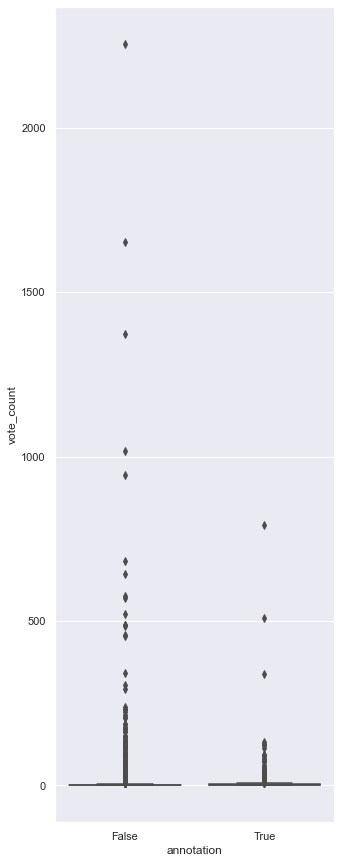

In [15]:
pdata = texts
pdata.annotation = pdata.annotation.astype('bool')
fig, ax = plt.subplots(figsize=(5,15))
sns.boxplot(data=pdata, y="vote_count", x='annotation')

### How does content offensiveness affect the popularity of the posts? 

In [69]:
pdata.groupby('annotation').vote_count.median()

annotation
False    1
True     1
Name: vote_count, dtype: int64

(0.0, 50.0)

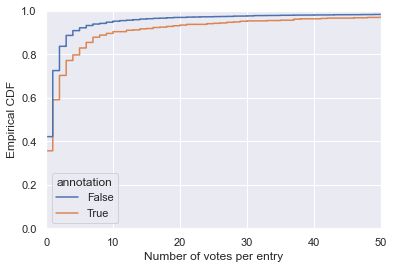

In [16]:
sns.ecdfplot(data=pdata, x="vote_count", hue="annotation")
plt.xlabel("Number of votes per entry")
plt.ylabel("Empirical CDF")
plt.xlim(0, 50)

In [17]:
texts.groupby('annotation').mean()

,Unnamed: 0,comment_id,entry_id,vote_count,hate_word_counts,is_hateful
annotation,,,,,,
False,8905.709336,1.769914e+08,5.001550e+07,5.811742,0.083734,0.075265
True,7336.228435,1.775064e+08,5.015432e+07,8.012780,0.389776,0.309904



### Can we identify most controversial topics? 

In [18]:
merged_tags = tags.merge(texts, how='left', on='entry_id').dropna(subset=['comment_id_y'])

In [19]:
merged_tags.tag.nunique()

1349

In [20]:
controversial = merged_tags[merged_tags.annotation==1].groupby(['tag']).count().reset_index()

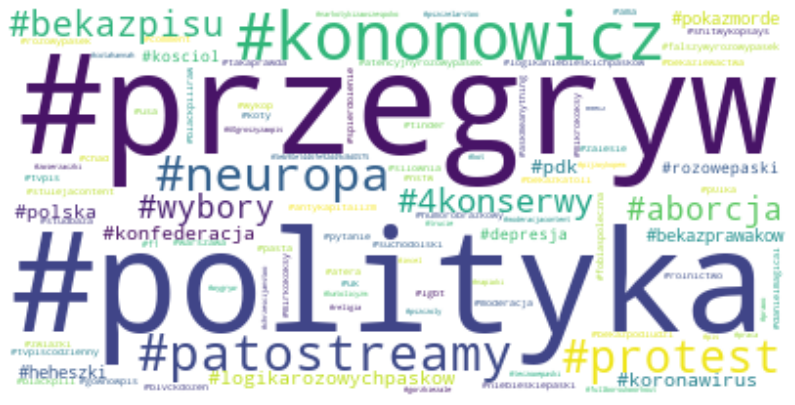

In [21]:
wc = WordCloud(background_color="white")
wc.generate_from_frequencies({tag: an for tag, an in zip(controversial.tag, controversial.comment_id_y)})
plt.figure(figsize=(14,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


### Can we relate any user or demographic features with offensive content?

In [22]:
profiles = pd.read_csv('../wykop_scraper/data/latest/profiles.csv')

In [23]:
profiles['author_login'] = profiles['login']

In [24]:
profiles.head()

,login,color,sex,avatar,signup_at,links_added_count,links_published_count,comments_count,rank,followers,following,entries,entries_comments,diggs,about,city,background,www,name,author_login
0,kojos,1,male,https://www.wykop.pl/cdn/c3397992/kojos_HMJFKh...,2009-01-26 20:58:20,30,12,40,0,23,28,1595,4406,4263,NaN,NaN,https://www.wykop.pl/cdn/c3397992/profile_back...,NaN,NaN,kojos
1,Jell-o,1,male,https://www.wykop.pl/cdn/c3397992/Jell-o_2S7nP...,2019-02-26 15:40:59,0,0,44,0,5,4,76,2575,45,NaN,Właśnie tam,https://www.wykop.pl/cdn/c3397992/profile_back...,NaN,Zrzekłem się,Jell-o
2,duszy-szum,1,NaN,https://www.wykop.pl/cdn/c3397992/duszy-szum_1...,2020-02-21 17:21:22,1,0,9,0,0,1,2,23,20,NaN,NaN,NaN,NaN,NaN,duszy-szum
3,Domq,1,male,https://www.wykop.pl/cdn/c3397992/Domq_oIJd2AN...,2016-12-24 10:10:26,1,0,24,0,0,8,65,219,305,NaN,NaN,NaN,NaN,NaN,Domq
4,ClinicalDepression,1,female,https://www.wykop.pl/cdn/c3397992/ClinicalDepr...,2019-05-04 10:39:51,0,0,0,0,1,4,2,29,1,NaN,NaN,NaN,NaN,NaN,ClinicalDepression


In [25]:
texts = texts.merge(profiles, how='left', on='author_login')

<AxesSubplot:title={'center':'Annotations for male/females'}, xlabel='sex', ylabel='count'>

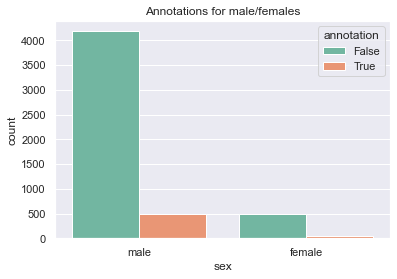

In [26]:
plt.title('Annotations for male/females')
sns.countplot(data=texts, x='sex', hue='annotation', palette='Set2')

In [27]:
profiles.city.nunique()

3886

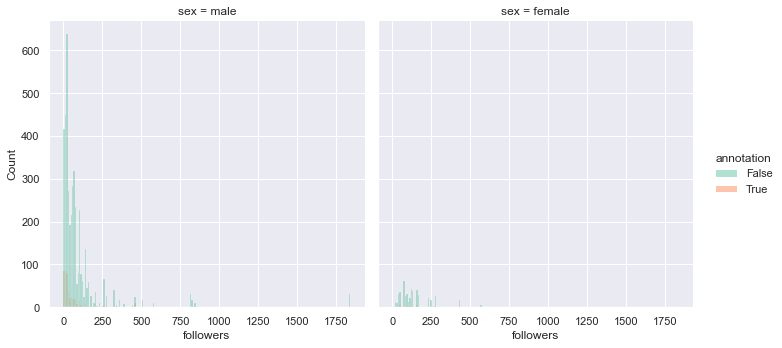

In [28]:
sns.displot(data=texts, col='sex', x='followers', hue='annotation', palette='Set2')
#plt.title('Followers for male/females')

In [29]:
texts.groupby('sex').mean()

,Unnamed: 0,comment_id,entry_id,vote_count,hate_word_counts,is_hateful,annotation,color,links_added_count,links_published_count,comments_count,rank,followers,following,entries,entries_comments,diggs
sex,,,,,,,,,,,,,,,,,
female,9478.135238,1.776966e+08,5.020826e+07,6.933333,0.083810,0.078095,0.076190,1.049524,48.657143,13.139048,867.843810,81.289524,139.314286,69.081905,1566.708571,11030.756190,2904.750476
male,8601.736605,1.767635e+08,4.995332e+07,6.147235,0.117874,0.101372,0.103515,85.699314,132.614445,25.380840,1859.753751,536.532362,93.124946,53.562152,3005.626447,17207.234033,3665.651307


In [59]:
comments_merged = texts.merge(profiles, left_on='receiver', right_on='login', how='left', suffixes=('', '_receiver'))


In [60]:
comments_merged.groupby('sex_receiver').mean()

,Unnamed: 0,comment_id,entry_id,vote_count,hate_word_counts,is_hateful,annotation,color,links_added_count,links_published_count,...,color_receiver,links_added_count_receiver,links_published_count_receiver,comments_count_receiver,rank_receiver,followers_receiver,following_receiver,entries_receiver,entries_comments_receiver,diggs_receiver
sex_receiver,,,,,,,,,,,,,,,,,,,,,
female,8447.387387,1.778232e+08,5.024296e+07,14.890390,0.130631,0.112613,0.136637,130.001517,238.889226,48.959029,...,1.066066,47.249249,13.184685,622.238739,102.872372,140.774775,69.744745,2109.618619,10526.984985,2554.130631
male,8744.586438,1.766967e+08,4.993516e+07,4.847054,0.109619,0.094671,0.095537,63.519342,102.399956,19.500667,...,82.963605,139.803726,27.812608,1808.537262,547.720754,130.739385,57.823873,4167.660529,18729.067808,4212.729636


In [61]:
comments_merged.groupby(['sex', 'sex_receiver']).mean()

Unnamed: 0    comment_id      entry_id  vote_count  \
sex    sex_receiver                                                        
female female        9621.403226  1.767930e+08  4.997077e+07    5.548387   
       male          9412.638889  1.775385e+08  5.016368e+07    7.354167   
male   female        8248.649374  1.778584e+08  5.025108e+07   16.758497   
       male          8637.606415  1.763774e+08  4.984854e+07    4.679261   

                     hate_word_counts  is_hateful  annotation       color  \
sex    sex_receiver                                                         
female female                0.016129    0.016129    0.096774    1.032258   
       male                  0.097222    0.090278    0.071759    1.055556   
male   female                0.148479    0.127013    0.144902  151.286225   
       male                  0.107910    0.092960    0.089426   73.353357   

                     links_added_count  links_published_count  ...  \
sex    sex_receiver                                            ...   
female female                16.645161               4.000000  ...   
       male                  56.016204              15.280093  ...   
male   female               278.717352              57.130590  ...   
       male                 117.938842              21.961131  ...   

                     color_receiver  links_added_count_receiver  \
sex    sex_receiver                                               
female female              1.064516                   12.032258   
       male              105.210648                  371.756944   
male   female              1.067979                   49.642218   
       male               82.081816                  124.101386   

                     links_published_count_receiver  comments_count_receiver  \
sex    sex_receiver                                                            
female female                              3.403226               736.967742   
       male                               76.824074              2370.138889   
male   female                             13.898032               613.788909   
       male                               24.288122              1760.489535   

                     rank_receiver  followers_receiver  following_receiver  \
sex    sex_receiver                                                          
female female           137.387097          137.241935           56.419355   
       male             481.395833          123.331019           65.641204   
male   female            99.776386          143.479428           71.481216   
       male             532.503669          133.102745           59.304159   

                     entries_receiver  entries_comments_receiver  \
sex    sex_receiver                                                
female female             2591.854839                9359.983871   
       male               3914.527778               19705.516204   
male   female             2006.998211               10614.749553   
       male               4268.567546               18923.837184   

                     diggs_receiver  
sex    sex_receiver                  
female female            912.290323  
       male             4909.997685  
male   female           2667.255814  
       male             4159.568361  

[4 rows x 27 columns]

In [62]:
tags.tag.nunique()

17418